### Import librarys

In [1]:
%time
import requests
import folium
import json
import io
import datetime
import time
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import base64
from io import BytesIO
import os
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import PathCollection
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import plotly.graph_objects as go
import plotly.express as px

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


### headers/date -utilities.py

In [2]:
%time
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
def get_api_headers():
    client_id = 'cd2d3ad1-94e4-4a2f-8bac-40c9db83e1f2'
    client_secret = 'oQuxOWArbMnmGeMrkxQnTCmvx6XykM6O'

    # Create a session
    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)

    # Get token for the session
    token_url = 'https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token'
    token = oauth.fetch_token(token_url=token_url, client_secret=client_secret, include_client_id=True)

    # Headers for the request
    headers = {
        'Authorization': f'Bearer {token["access_token"]}',
        'Content-Type': 'application/json'}

    return headers
headers=get_api_headers()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [3]:
%time
def get_dates():
    # Get the current date and time in UTC
    today = datetime.datetime.utcnow()
    # Subtract 48 hours (2 days) from the current date and time
    from_time = today - datetime.timedelta(hours=48)
    # Format the dates as strings in the desired format
    today_str = today.strftime("%Y-%m-%dT%H:%M:%SZ")
    from_time_str = from_time.strftime("%Y-%m-%dT%H:%M:%SZ")

    return today_str, from_time_str

# Example of how to use the function
current_time, past_time = get_dates()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


### retrive_data.py

#### carbon monoxide

In [4]:
%time
url = "https://creodias.sentinel-hub.com/api/v1/process"
def get_carbon_monoxide_data():

    evalscript = """
    //VERSION=3
    //S5P Carbon Monoxide total column mol/m2 (CO)
    var minVal = 0.0;
    var maxVal = 0.1;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["CO","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.CO);
        const statsVal = isFinite(samples.CO) ? samples.CO : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_co = Image.open(io.BytesIO(image_data))
        return image_co
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_co=get_carbon_monoxide_data()

CPU times: user 14 µs, sys: 3 µs, total: 17 µs
Wall time: 66 µs


#### nitrogen dioxide

In [5]:
%time
def get_nitrogen_dioxide_data():

    evalscript = """
    //VERSION=3
    //S5P Nitrogen Dioxide tropospheric column mol/m2 (NO2)
    var minVal = 0.0;
    var maxVal = 0.0003;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["NO2","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.NO2);
        const statsVal = isFinite(samples.NO2) ? samples.NO2 : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_no2 = Image.open(io.BytesIO(image_data))
        return image_no2
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_no2=get_nitrogen_dioxide_data()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


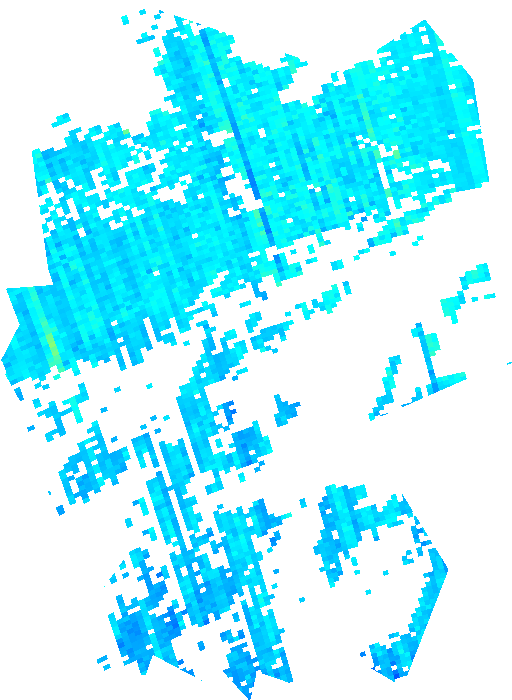

In [6]:
display(image_co)

#### Formaldehyde troposheric vertical column (mol/m2) NCHO

In [7]:
%time
def get_formaldehyde_data():

    evalscript = """
    //VERSION=3
    //S5P Formaldehyde tropospheric vertical column mol/m2 (HCHO)
    var minVal = 0.0;
    var maxVal = 0.001;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["HCHO","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.HCHO);
        const statsVal = isFinite(samples.HCHO) ? samples.HCHO : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_hcho = Image.open(io.BytesIO(image_data))
        return image_hcho
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_hcho=get_formaldehyde_data()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


#### Ozone total column (mol/m2) O3

In [8]:
%time
def get_ozone_data():

    evalscript = """
    //VERSION=3
    //S5P Ozone total column mol/m2 (O3)
    var minVal = 0.0
    var maxVal = 0.36;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["O3","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.O3);
        const statsVal = isFinite(samples.O3) ? samples.O3 : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_o3 = Image.open(io.BytesIO(image_data))
        return image_o3
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_o3=get_ozone_data()

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 20 µs


#### Sulfur dioxide total column (mol/m2) SO2

In [9]:
%time
def get_sulfur_data():

    evalscript = """
    //VERSION=3
    //S5P Sulfur dioxide total column mol/m2 (SO2)
    var minVal = 0.0;
    var maxVal = 0.01;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["SO2","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.SO2);
        const statsVal = isFinite(samples.SO2) ? samples.SO2 : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_so2 = Image.open(io.BytesIO(image_data))
        return image_so2
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_so2=get_sulfur_data()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


#### AER_AI_340_380-UV aerosol index from 380 and 340 nm (unitless)

In [10]:
%time
def get_AER_AI_340_380_data():

    evalscript = """
    //VERSION=3
    //S5P UV aerosol index from 380 and 340 nm (unitless)
    var minVal = -1;
    var maxVal = 5;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["AER_AI_340_380","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.AER_AI_340_380);
        const statsVal = isFinite(samples.AER_AI_340_380) ? samples.AER_AI_340_380 : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_aer_380 = Image.open(io.BytesIO(image_data))
        return image_aer_380
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_aer_380=get_AER_AI_340_380_data()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


#### Column averaged dry air mixing ratio of methane (parts per billion) CH4

In [11]:
%time
def get_methane_data():

    evalscript = """
    //VERSION=3
    //S5P Column averaged dry air mixing ratio of methane (parts per billion PPB) (CH4)
    var minVal = 1600.0;
    var maxVal = 2000.0;
    var diff = maxVal - minVal;
    const map = [
        [minVal, 0x00007f],
        [minVal + 0.125 * diff, 0x0000ff],
        [minVal + 0.375 * diff, 0x00ffff],
        [minVal + 0.625 * diff, 0xffff00],
        [minVal + 0.875 * diff, 0xff0000],
        [maxVal, 0x7f0000]
    ];

    const visualizer = new ColorRampVisualizer(map)
    function setup() {
        return {
            input: [
                {
                    bands: ["CH4","dataMask"],
                    metadata: ["bounds"],
                }
            ],
            output: [
                {
                    id: "default",
                    bands: 4,
                },
            ],
        };
    }
    function evaluatePixel(samples) {
        const [r, g, b] = visualizer.process(samples.CH4);
        const statsVal = isFinite(samples.CH4) ? samples.CH4 : NaN;
        return {
            default: [r, g, b, samples.dataMask],
            eobrowserStats: [statsVal],
            dataMask: [samples.dataMask],
        };
    }
    """
    # Define the payload with coordinates and other parameters
    payload = {
        "input": {
            "bounds": {
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                },
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates": [
                        [
                            [
                                [8.131946, 55.128649],
                                [11.954962, 54.303704],
                                [13.427042, 54.901882],
                                [14.283925, 54.226708],
                                [14.569553, 53.094024],
                                [14.327868, 52.656394],
                                [14.987008, 51.041394],
                                [14.327868, 50.903033],
                                [12.262561, 50.331436],
                                [13.844498, 48.705463],
                                [13.030709, 47.390912],
                                [12.217769, 47.694974],
                                [11.009344, 47.435519],
                                [10.427103, 47.561701],
                                [10.306261, 47.23449],
                                [9.756977, 47.61357],
                                [9.515292, 47.435519],
                                [8.570524, 47.754098],
                                [8.438019, 47.52091],
                                [7.658036, 47.543164],
                                [7.531701, 47.779943],
                                [7.61378, 48.416442],
                                [8.218246, 48.951366],
                                [7.087178, 49.088258],
                                [6.549782, 49.79545],
                                [6.154298, 50.190968],
                                [6.308097, 50.499452],
                                [5.846699, 51.027576],
                                [6.208104, 51.467697],
                                [5.966419, 51.869708],
                                [6.812316, 51.910391],
                                [6.713445, 52.106505],
                                [6.361903, 53.690201],
                                [8.131946, 55.128649]
                            ]
                        ]
                    ]
                }
            },
            "data": [
                {
                    "dataFilter": {
                        "timeRange": {
                            "from": past_time,
                            "to": current_time
                        },
                        "mosaickingOrder": "mostRecent"
                    },
                    "processing": {
                        "minQa": "50"
                    },
                    "type": "sentinel-5p-l2"
                }
            ]
        },
        "output": {
            "width": 512,
            "height": 700,
            "responses": [
                {
                    "identifier": "default",
                    "format": {
                        "type": "image/png"
                    }
                }
            ]
        },
        "evalscript": evalscript
    }


    # Send the POST request to the API endpoint
    response = requests.post(url, headers=get_api_headers(), json=payload)

    # Handle the response
    if response.status_code == 200:
        image_data = response.content
        image_ch4 = Image.open(io.BytesIO(image_data))
        return image_ch4
        # Process the response content if needed
    else:
        print(f"Request failed with status code: {response.status_code}")
        print("Response content:", response.text)
        return None
image_ch4=get_methane_data()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


### image dict

In [12]:
%time
image_dict={"CO":{"image":image_co,"minVal":0.0,"maxVal": 0.1},
            "NO2":{"image":image_no2, "minVal":0.0,"maxVal": 0.0003},
            "HCHO":{"image":image_hcho,"minVal":0.0,"maxVal": 0.001},
            "O3":{"image":image_o3, "minVal":0.0,"maxVal": 0.36},
            "SO2":{"image":image_so2, "minVal":0.0,"maxVal": 0.01},
            "AER":{"image":image_aer_380,"minVal":-1,"maxVal": 5},
            "CH4":{"image":image_ch4, "minVal":1600.0,"maxVal": 2000.0}}

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [13]:
image_dict.items()

dict_items([('CO', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87712FB0>, 'minVal': 0.0, 'maxVal': 0.1}), ('NO2', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBAD1838F70>, 'minVal': 0.0, 'maxVal': 0.0003}), ('HCHO', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87598E50>, 'minVal': 0.0, 'maxVal': 0.001}), ('O3', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87562500>, 'minVal': 0.0, 'maxVal': 0.36}), ('SO2', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA8759B4F0>, 'minVal': 0.0, 'maxVal': 0.01}), ('AER', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87710B20>, 'minVal': -1, 'maxVal': 5}), ('CH4', {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87598FA0>, 'minVal': 1600.0, 'maxVal': 2000.0})])

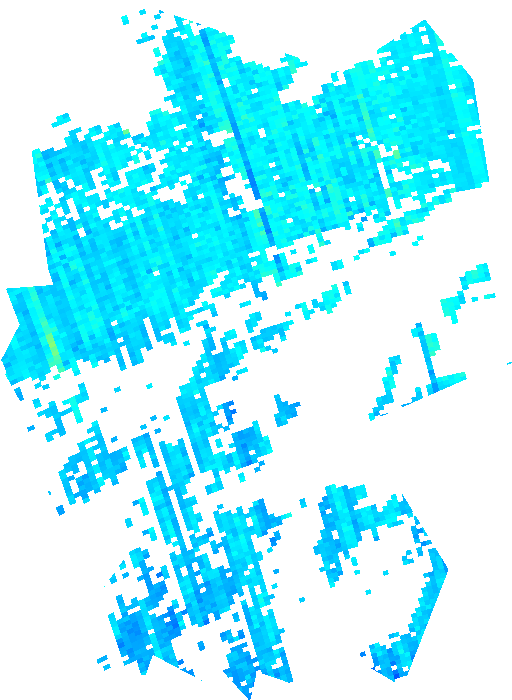

In [14]:
display(image_co)

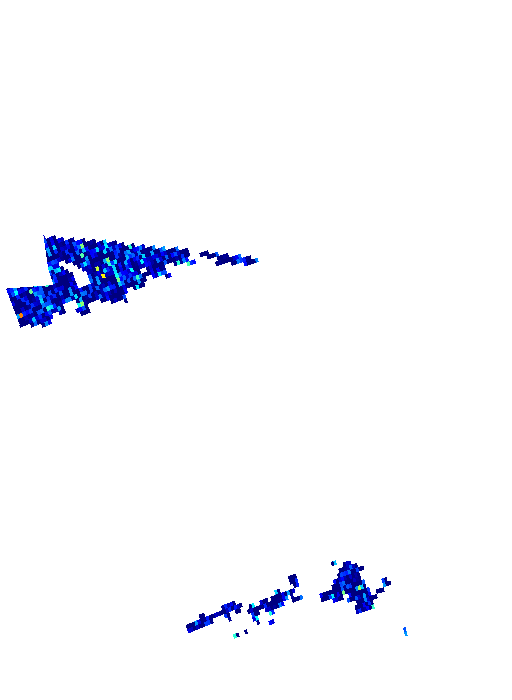

In [15]:
image_hcho

### image_array.py

In [16]:
%time
def image_array(image):
    image_array = np.array(image)
    return image_array
# image url
def image_to_data_uri(image):
    """
    Encodes an image to Base64, converts it to JSON, and then creates a Data URI.

    Args:
    image_path (str): The path to the image file.

    Returns:
    str: A Data URI representing the image.
    """

    def encode_image_to_json(path):
        """
        Encodes an image to Base64 and then converts it to JSON.

        Args:
        path (str): The path to the image file.

        Returns:
        str: A JSON string containing the Base64 encoded image.
        """
        buffered = io.BytesIO()
        image.save(buffered, format=image.format)
        encoded_string = base64.b64encode(buffered.getvalue()).decode()
        # Create a dictionary to hold the image data and convert it to JSON
        image_json = {"image": encoded_string}
        json_str=json.dumps(image_json)
        return json_str

    # Encode the image to JSON
    json_str = encode_image_to_json(image)

    # Extract the Base64 encoded string from the JSON
    image_data = json.loads(json_str)
    base64_string = image_data["image"]

    # Create the Data URI
    data_uri = f"data:image/png;base64,{base64_string}"
    return data_uri

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [17]:
%time
image_uris = {key: image_to_data_uri(value.get('image')) for key, value in image_dict.items()}
image_arrays = {key: image_array(value.get('image')) for key, value in image_dict.items()}
image_shapes = {key: value.shape for key, value in image_arrays.items()}

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [18]:
image_uris.keys()

dict_keys(['CO', 'NO2', 'HCHO', 'O3', 'SO2', 'AER', 'CH4'])

In [19]:
image_arrays

{'CO': array([[[127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         ...,
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0]],
 
        [[127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         ...,
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0]],
 
        [[127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         ...,
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0]],
 
        ...,
 
        [[127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         ...,
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0]],
 
        [[127,   0,   0,   0],
         [127,   0,   0,   0],
         [127,   0,   0,   0],
         ...,
         [127,   0,   0,   0],
         [127,   0,   0,   0]

In [20]:
image_shapes

{'CO': (700, 512, 4),
 'NO2': (700, 512, 4),
 'HCHO': (700, 512, 4),
 'O3': (700, 512, 4),
 'SO2': (700, 512, 4),
 'AER': (700, 512, 4),
 'CH4': (700, 512, 4)}

### color_values.py

In [21]:
%time
def create_legend(minVal, maxVal):
    def hex_to_rgb(hex_color):
        """
        Converts a hex color to an RGB tuple.

        Args:
        hex_color (str): Hex color string.

        Returns:
        tuple: Corresponding RGB tuple.
        """
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    """
    Creates a DataFrame representing a CO legend with levels and colors.

    Args:
    minVal (float): Minimum value of the range.
    maxVal (float): Maximum value of the range.

    Returns:
    DataFrame: CO levels with corresponding colors.
    """
    diff = maxVal - minVal
    colors = ['0x00007f', '0x0000ff', '0x00ffff', '0xffff00', '0xff0000', '0x7f0000']

    levels = np.array([minVal,
                       minVal + 0.125 * diff,
                       minVal + 0.375 * diff,
                       minVal + 0.625 * diff,
                       minVal + 0.875 * diff,
                       maxVal])

    levels = np.round(levels, 4)
    legend_df = pd.DataFrame({'Level': levels, 'Color': colors})
    legend_df['Color'] = legend_df['Color'].apply(lambda x: f"#{x[2:]}")
    legend_df['RGB'] = legend_df['Color'].apply(hex_to_rgb)
    return legend_df

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.3 µs


In [22]:
%time
def create_color_value_table(legend_df):
        """
        Creates a dictionary mapping RGB colors to CO levels.

        Args:
        legend_df (DataFrame): DataFrame with CO levels and colors.

        Returns:
        dict: Mapping of RGB colors to CO levels.
        """
        return {rgb: level for rgb, level in zip(legend_df['RGB'], legend_df['Level'])}

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs


In [23]:
%time
legend_dfs= {key: create_legend(value.get('minVal'), value.get('maxVal')) for key, value in image_dict.items()}
color_value_tables = {key: create_color_value_table(legend_df) for key, legend_df in legend_dfs.items()}

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [24]:
legend_dfs

{'CO':     Level    Color            RGB
 0  0.0000  #00007f    (0, 0, 127)
 1  0.0125  #0000ff    (0, 0, 255)
 2  0.0375  #00ffff  (0, 255, 255)
 3  0.0625  #ffff00  (255, 255, 0)
 4  0.0875  #ff0000    (255, 0, 0)
 5  0.1000  #7f0000    (127, 0, 0),
 'NO2':     Level    Color            RGB
 0  0.0000  #00007f    (0, 0, 127)
 1  0.0000  #0000ff    (0, 0, 255)
 2  0.0001  #00ffff  (0, 255, 255)
 3  0.0002  #ffff00  (255, 255, 0)
 4  0.0003  #ff0000    (255, 0, 0)
 5  0.0003  #7f0000    (127, 0, 0),
 'HCHO':     Level    Color            RGB
 0  0.0000  #00007f    (0, 0, 127)
 1  0.0001  #0000ff    (0, 0, 255)
 2  0.0004  #00ffff  (0, 255, 255)
 3  0.0006  #ffff00  (255, 255, 0)
 4  0.0009  #ff0000    (255, 0, 0)
 5  0.0010  #7f0000    (127, 0, 0),
 'O3':    Level    Color            RGB
 0  0.000  #00007f    (0, 0, 127)
 1  0.045  #0000ff    (0, 0, 255)
 2  0.135  #00ffff  (0, 255, 255)
 3  0.225  #ffff00  (255, 255, 0)
 4  0.315  #ff0000    (255, 0, 0)
 5  0.360  #7f0000    (127, 0, 

In [25]:
color_value_tables

{'CO': {(0, 0, 127): 0.0,
  (0, 0, 255): 0.0125,
  (0, 255, 255): 0.0375,
  (255, 255, 0): 0.0625,
  (255, 0, 0): 0.0875,
  (127, 0, 0): 0.1},
 'NO2': {(0, 0, 127): 0.0,
  (0, 0, 255): 0.0,
  (0, 255, 255): 0.0001,
  (255, 255, 0): 0.0002,
  (255, 0, 0): 0.0003,
  (127, 0, 0): 0.0003},
 'HCHO': {(0, 0, 127): 0.0,
  (0, 0, 255): 0.0001,
  (0, 255, 255): 0.0004,
  (255, 255, 0): 0.0006,
  (255, 0, 0): 0.0009,
  (127, 0, 0): 0.001},
 'O3': {(0, 0, 127): 0.0,
  (0, 0, 255): 0.045,
  (0, 255, 255): 0.135,
  (255, 255, 0): 0.225,
  (255, 0, 0): 0.315,
  (127, 0, 0): 0.36},
 'SO2': {(0, 0, 127): 0.0,
  (0, 0, 255): 0.0012,
  (0, 255, 255): 0.0038,
  (255, 255, 0): 0.0062,
  (255, 0, 0): 0.0088,
  (127, 0, 0): 0.01},
 'AER': {(0, 0, 127): -1.0,
  (0, 0, 255): -0.25,
  (0, 255, 255): 1.25,
  (255, 255, 0): 2.75,
  (255, 0, 0): 4.25,
  (127, 0, 0): 5.0},
 'CH4': {(0, 0, 127): 1600.0,
  (0, 0, 255): 1650.0,
  (0, 255, 255): 1750.0,
  (255, 255, 0): 1850.0,
  (255, 0, 0): 1950.0,
  (127, 0, 0): 20

### bounds.py

In [26]:
%time
coordinates = [
    [[[8.131946, 55.128649], [11.954962, 54.303704], [13.427042, 54.901882],
      [14.283925, 54.226708], [14.569553, 53.094024], [14.327868, 52.656394],
      [14.987008, 51.041394], [14.327868, 50.903033], [12.262561, 50.331436],
      [13.844498, 48.705463], [13.030709, 47.390912], [12.217769, 47.694974],
      [11.009344, 47.435519], [10.427103, 47.561701], [10.306261, 47.23449],
      [9.756977, 47.61357], [9.515292, 47.435519], [8.570524, 47.754098],
      [8.438019, 47.52091], [7.658036, 47.543164], [7.531701, 47.779943],
      [7.61378, 48.416442], [8.218246, 48.951366], [7.087178, 49.088258],
      [6.549782, 49.79545], [6.154298, 50.190968], [6.308097, 50.499452],
      [5.846699, 51.027576], [6.208104, 51.467697], [5.966419, 51.869708],
      [6.812316, 51.910391], [6.713445, 52.106505], [6.361903, 53.690201],
      [8.131946, 55.128649]]]
]

def find_bounds(coordinates):
    # Initialize min and max values
    min_lat, max_lat = 90, -90
    min_lon, max_lon = 180, -180

    # Iterate through each polygon in the MultiPolygon
    for polygon in coordinates:
        for coord in polygon[0]:  # Assuming each polygon is a list of coordinates
            lon, lat = coord
            min_lat = min(lat, min_lat)
            max_lat = max(lat, max_lat)
            min_lon = min(lon, min_lon)
            max_lon = max(lon, max_lon)

    # Now you have your bounds
    bounds = [[max_lat, min_lon], [min_lat, max_lon]]  # [[top left], [bottom right]
    top_left_coords=bounds[0]
    bottom_right_coords=bounds[1]
    return bounds,top_left_coords,bottom_right_coords
bounds, top_left_coords, bottom_right_coords = find_bounds(coordinates)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


### admin_unit.py

In [27]:
%time
file_path = '/home/anamaria/code/nusero92/DSS/boundaries/geo_zip_simple.geojson'
geo_zip_simple = gpd.read_file(file_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [28]:
geo_zip_simple

,plz_name,lan_name,geometry
0,Hagen,Nordrhein-Westfalen,"POLYGON ((7.44706 51.38811, 7.45165 51.39092, ..."
1,Lünen,Nordrhein-Westfalen,"POLYGON ((7.45345 51.63917, 7.45356 51.63939, ..."
2,Gummersbach,Nordrhein-Westfalen,"POLYGON ((7.49289 50.98213, 7.49290 50.98232, ..."
3,Ochtersum,Niedersachsen,"POLYGON ((7.49399 53.60976, 7.49940 53.61586, ..."
4,Dortmund,Nordrhein-Westfalen,"POLYGON ((7.49587 51.46124, 7.49938 51.46151, ..."
...,...,...,...
8929,Maßweiler,Rheinland-Pfalz,"POLYGON ((7.49045 49.27053, 7.49166 49.27155, ..."
8930,Schwerte,Nordrhein-Westfalen,"POLYGON ((7.50323 51.42493, 7.50365 51.42523, ..."
8931,Koblenz,Rheinland-Pfalz,"POLYGON ((7.55646 50.36300, 7.55730 50.36450, ..."
8932,Rhens,Rheinland-Pfalz,"POLYGON ((7.55786 50.28334, 7.55861 50.28343, ..."


In [29]:
%time
def add_rgb_values_to_units(geo_zip_simple, image_array, image_shape, top_left_coords, bottom_right_coords, column_name):
    def extract_rgb_values(x, y, image_shape, image_array):
        if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
            return image_array[y, x, :3].tolist()  # Extract RGB values
        return None  # Return None if coordinates are out of bounds
    
    # Vectorized approach for coordinate conversion
    centroids =geo_zip_simple['geometry'].centroid
    lat_rel = (top_left_coords[0] - centroids.y) / (top_left_coords[0] - bottom_right_coords[0])
    lon_rel = (centroids.x - top_left_coords[1]) / (bottom_right_coords[1] - top_left_coords[1])
    
    x_coords = (lon_rel * image_shape[1]).astype(int)
    y_coords = (lat_rel * image_shape[0]).astype(int)
    
    # Vectorized approach for RGB value assignment
    rgb_values = [extract_rgb_values(x, y, image_shape, image_array) for x, y in zip(x_coords, y_coords)]
    geo_zip_simple[column_name] = rgb_values

    return geo_zip_simple


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.48 µs


In [30]:
%time
# Dictionary to store updated GeoDataFrames for each pollutant
geo_zip_updated = geo_zip_simple.copy()

for pollutant, image_array in image_arrays.items():
    image_shape = image_shapes[pollutant]
    top_left_coords, bottom_right_coords = top_left_coords, bottom_right_coords

    # Add a new column for each pollutant's RGB values
    geo_zip_updated = add_rgb_values_to_units(
        geo_zip_updated, 
        image_array, 
        image_shape, 
        top_left_coords, 
        bottom_right_coords, 
        f"{pollutant}_rgb"
    )

# Now geo_zip_updated contains the updated GeoDataFrames for each pollutant


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


/tmp/ipykernel_6211/1452762387.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids =geo_zip_simple['geometry'].centroid
/tmp/ipykernel_6211/1452762387.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids =geo_zip_simple['geometry'].centroid
/tmp/ipykernel_6211/1452762387.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids =geo_zip_simple['geometry'].centroid
/tmp/ipykernel_6211/1452762387.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a pro

In [31]:
geo_zip_updated

,plz_name,lan_name,geometry,CO_rgb,NO2_rgb,HCHO_rgb,O3_rgb,SO2_rgb,AER_rgb,CH4_rgb
0,Hagen,Nordrhein-Westfalen,"POLYGON ((7.44706 51.38811, 7.45165 51.39092, ...","[0, 231, 255]","[255, 202, 0]","[127, 0, 0]","[70, 255, 185]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]"
1,Lünen,Nordrhein-Westfalen,"POLYGON ((7.45345 51.63917, 7.45356 51.63939, ...","[0, 242, 255]","[127, 0, 0]","[127, 0, 0]","[71, 255, 184]","[127, 0, 0]","[0, 0, 180]","[127, 0, 0]"
2,Gummersbach,Nordrhein-Westfalen,"POLYGON ((7.49289 50.98213, 7.49290 50.98232, ...","[8, 255, 247]","[0, 153, 255]","[127, 0, 0]","[68, 255, 187]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]"
3,Ochtersum,Niedersachsen,"POLYGON ((7.49399 53.60976, 7.49940 53.61586, ...","[1, 255, 254]","[0, 0, 127]","[127, 0, 0]","[76, 255, 179]","[127, 0, 0]","[0, 0, 132]","[127, 0, 0]"
4,Dortmund,Nordrhein-Westfalen,"POLYGON ((7.49587 51.46124, 7.49938 51.46151, ...","[23, 255, 232]","[127, 0, 0]","[127, 0, 0]","[69, 255, 186]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...
8929,Maßweiler,Rheinland-Pfalz,"POLYGON ((7.49045 49.27053, 7.49166 49.27155, ...","[127, 0, 0]","[127, 0, 0]","[127, 0, 0]","[43, 255, 212]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]"
8930,Schwerte,Nordrhein-Westfalen,"POLYGON ((7.50323 51.42493, 7.50365 51.42523, ...","[23, 255, 232]","[168, 255, 87]","[127, 0, 0]","[62, 255, 193]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]"
8931,Koblenz,Rheinland-Pfalz,"POLYGON ((7.55646 50.36300, 7.55730 50.36450, ...","[0, 240, 255]","[127, 0, 0]","[127, 0, 0]","[59, 255, 196]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]"
8932,Rhens,Rheinland-Pfalz,"POLYGON ((7.55786 50.28334, 7.55861 50.28343, ...","[0, 216, 255]","[127, 0, 0]","[127, 0, 0]","[55, 255, 200]","[127, 0, 0]","[0, 0, 165]","[127, 0, 0]"


In [32]:
%time
from scipy.spatial import KDTree

# Function to create KD-tree for a given color value table
def create_tree_for_color_value_table(color_value_table):
    color_points = list(color_value_table.keys())  # Get the RGB color points
    return KDTree(color_points)

# Creating KD-trees for each pollutant's color value table
trees = {pollutant: create_tree_for_color_value_table(color_value_table) 
         for pollutant, color_value_table in color_value_tables.items()}



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [33]:
%time
def get_value_from_color_optimized(rgb_color, tree, value_table):
    # Query the KD-tree to find the nearest RGB color
    distance, index = tree.query(rgb_color)
    nearest_color = tree.data[index]
    
    # Convert the nearest_color to a tuple of integers
    nearest_color_tuple = tuple(nearest_color.astype(int))
    
    # Retrieve the corresponding value from the value table
    value = value_table.get(nearest_color_tuple, None)
    
    return value


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


### Add values to administrative unit

In [34]:
%time
def vectorized_value_conversion(df, pollutant, tree, value_table):
    # Extract the RGB columns for the pollutant
    rgb_values = df[f"{pollutant}_rgb"].apply(pd.Series)

    # Vectorized query of KD-tree
    distances, indices = tree.query(rgb_values)

    # Convert indices to nearest colors and then to values
    nearest_colors = tree.data[indices].astype(int)
    values = [value_table.get(tuple(color), None) for color in nearest_colors]

    return values

def add_value_to_unit_vectorized(df, trees, color_value_tables):
    for pollutant in color_value_tables.keys():
        value_column = f"{pollutant}_value"
        tree = trees[pollutant]
        value_table = color_value_tables[pollutant]

        # Apply the vectorized conversion for each pollutant
        df[value_column] = vectorized_value_conversion(df, pollutant, tree, value_table)

    return df

# Usage
geo_zip_updated = add_value_to_unit_vectorized(geo_zip_updated, trees, color_value_tables)



CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [35]:
%time
#geo_zip_updated=geo_zip_updated.drop(columns=["CO_rgb","NO2_rgb","HCHO_rgb","O3_rgb","SO2_rgb","AER_rgb","CH4_rgb","geometry"])
geo_zip_updated

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


,plz_name,lan_name,geometry,CO_rgb,NO2_rgb,HCHO_rgb,O3_rgb,SO2_rgb,AER_rgb,CH4_rgb,CO_value,NO2_value,HCHO_value,O3_value,SO2_value,AER_value,CH4_value
0,Hagen,Nordrhein-Westfalen,"POLYGON ((7.44706 51.38811, 7.45165 51.39092, ...","[0, 231, 255]","[255, 202, 0]","[127, 0, 0]","[70, 255, 185]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]",0.0375,0.0002,0.001,0.135,0.01,-1.0,2000.0
1,Lünen,Nordrhein-Westfalen,"POLYGON ((7.45345 51.63917, 7.45356 51.63939, ...","[0, 242, 255]","[127, 0, 0]","[127, 0, 0]","[71, 255, 184]","[127, 0, 0]","[0, 0, 180]","[127, 0, 0]",0.0375,0.0003,0.001,0.135,0.01,-1.0,2000.0
2,Gummersbach,Nordrhein-Westfalen,"POLYGON ((7.49289 50.98213, 7.49290 50.98232, ...","[8, 255, 247]","[0, 153, 255]","[127, 0, 0]","[68, 255, 187]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]",0.0375,0.0001,0.001,0.135,0.01,-1.0,2000.0
3,Ochtersum,Niedersachsen,"POLYGON ((7.49399 53.60976, 7.49940 53.61586, ...","[1, 255, 254]","[0, 0, 127]","[127, 0, 0]","[76, 255, 179]","[127, 0, 0]","[0, 0, 132]","[127, 0, 0]",0.0375,0.0000,0.001,0.135,0.01,-1.0,2000.0
4,Dortmund,Nordrhein-Westfalen,"POLYGON ((7.49587 51.46124, 7.49938 51.46151, ...","[23, 255, 232]","[127, 0, 0]","[127, 0, 0]","[69, 255, 186]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]",0.0375,0.0003,0.001,0.135,0.01,-1.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8929,Maßweiler,Rheinland-Pfalz,"POLYGON ((7.49045 49.27053, 7.49166 49.27155, ...","[127, 0, 0]","[127, 0, 0]","[127, 0, 0]","[43, 255, 212]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]",0.1000,0.0003,0.001,0.135,0.01,-1.0,2000.0
8930,Schwerte,Nordrhein-Westfalen,"POLYGON ((7.50323 51.42493, 7.50365 51.42523, ...","[23, 255, 232]","[168, 255, 87]","[127, 0, 0]","[62, 255, 193]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]",0.0375,0.0002,0.001,0.135,0.01,-1.0,2000.0
8931,Koblenz,Rheinland-Pfalz,"POLYGON ((7.55646 50.36300, 7.55730 50.36450, ...","[0, 240, 255]","[127, 0, 0]","[127, 0, 0]","[59, 255, 196]","[127, 0, 0]","[0, 0, 127]","[127, 0, 0]",0.0375,0.0003,0.001,0.135,0.01,-1.0,2000.0
8932,Rhens,Rheinland-Pfalz,"POLYGON ((7.55786 50.28334, 7.55861 50.28343, ...","[0, 216, 255]","[127, 0, 0]","[127, 0, 0]","[55, 255, 200]","[127, 0, 0]","[0, 0, 165]","[127, 0, 0]",0.0375,0.0003,0.001,0.135,0.01,-1.0,2000.0


In [36]:
geo_zip_updated.groupby("lan_name")["CO_value"].mean()

lan_name
Baden-Württemberg         0.065866
Bayern                    0.083013
Berlin                    0.094949
Brandenburg               0.078204
Bremen                    0.044602
Hamburg                   0.051835
Hessen                    0.074529
Mecklenburg-Vorpommern    0.040010
Niedersachsen             0.049521
Nordrhein-Westfalen       0.047831
Rheinland-Pfalz           0.084784
Saarland                  0.094565
Sachsen                   0.090050
Sachsen-Anhalt            0.087709
Schleswig-Holstein        0.043026
Thüringen                 0.094141
Name: CO_value, dtype: float64

In [37]:
def top_lan_names_by_pollutant(df, pollutant, top_n=5):
    """
    Returns the top 'lan_name's with the highest average value for a given pollutant.

    :param df: pandas DataFrame containing the data
    :param pollutant: String, name of the pollutant column
    :param top_n: Integer, number of top 'lan_name's to return
    :return: pandas DataFrame with top 'lan_name's and their mean pollutant values
    """
    if pollutant not in df.columns:
        raise ValueError(f"Pollutant '{pollutant}' not found in DataFrame")

    grouped_df = df.groupby('lan_name')[pollutant].mean()
    return grouped_df

# Usage example
# Replace 'geo_zip_updated' with your actual DataFrame and 'CO_value' with the pollutant of your choice
# grouped_df = top_lan_names_by_pollutant(geo_zip_updated, 'CO_value')
# print(grouped_df)


In [38]:
grouped_df = top_lan_names_by_pollutant(geo_zip_updated, 'NO2_value')
grouped_df.sort_values()

lan_name
Mecklenburg-Vorpommern    0.000015
Schleswig-Holstein        0.000027
Niedersachsen             0.000048
Bremen                    0.000052
Hamburg                   0.000113
Nordrhein-Westfalen       0.000160
Brandenburg               0.000173
Sachsen-Anhalt            0.000194
Hessen                    0.000201
Berlin                    0.000224
Baden-Württemberg         0.000269
Thüringen                 0.000272
Bayern                    0.000276
Rheinland-Pfalz           0.000277
Sachsen                   0.000296
Saarland                  0.000299
Name: NO2_value, dtype: float64

In [43]:
pollutant_name_mapping = {
    'Carbon Monoxide (CO)': 'CO_value',
    'Nitrogen Dioxide (NO2)': 'NO2_value',
    'Formaldehyde (HCHO)': 'HCHO_value',
    'Ozone (O3)': 'O3_value',
    'Sulfur Dioxide (SO2)': 'SO2_value',
    'Methane (CH4)': 'CH4_value',
    'Aerosol (AER)': 'AER_value'
}

In [63]:

selected_pollutant_name = pollutant_name_mapping.keys()
selected_pollutant_name

dict_keys(['Carbon Monoxide (CO)', 'Nitrogen Dioxide (NO2)', 'Formaldehyde (HCHO)', 'Ozone (O3)', 'Sulfur Dioxide (SO2)', 'Methane (CH4)', 'Aerosol (AER)'])

In [82]:
def get_image_data(pollutant):
    """
    Get the data URI of the image corresponding to the specified pollutant.
    """
    if pollutant in image_dict:
        print(pollutant)
        image_info = image_dict[pollutant]
        if 'image' in image_info:
            image_path = image_info['image']  # Assuming this is the path to the image
            print(image_path)
            return print(image_to_data_uri(image_path))
    return None

CO
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87712FB0>


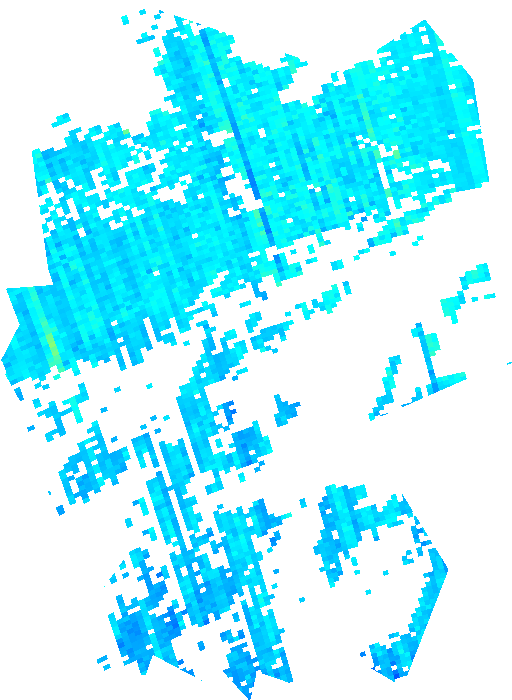

In [83]:
f=get_image_data("CO")
f

CH4
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87598FA0>, 'minVal': 1600.0, 'maxVal': 2000.0}
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x700 at 0x7FBA87598FA0>


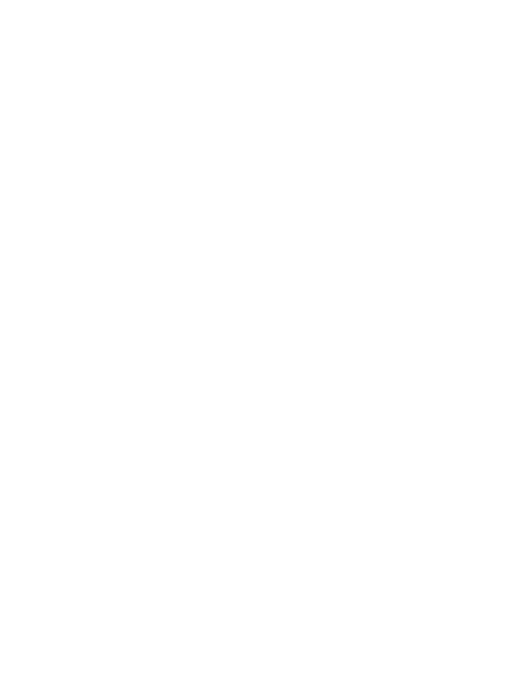

In [61]:
if pollutant in image_dict:
    print(pollutant)
    image_info = image_dict[pollutant]
    print(image_info)
    if 'image' in image_info:
            image_path = image_info['image']  # Assuming this is the path to the image
            print(image_path)
            print(image_to_data_uri(image_path))

In [78]:
selected_pollutant_name="Carbon Monoxide (CO)"
selected_pollutant_column = pollutant_name_mapping[selected_pollutant_name]
print(selected_pollutant_column)
image_path = get_image_data(selected_pollutant_column)
print(image_path)

CO_value
None


TypeError: unhashable type: 'dict_keys'